# Basic usage

The command line interface requires us to save and load the state of a Controller from file.
To initialize it, we can define a file `lib.py` with the code for the experiment:

In [ ]:
%cat lib.py

import numpy as np
from autora.experimentalist.pipeline import (
    make_pipeline as make_experimentalist_pipeline,
)
from autora.variable import Variable, VariableCollection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline as make_theorist_pipeline
from sklearn.preprocessing import PolynomialFeatures

from autora.workflow import Controller

rng = np.random.default_rng(180)

experimentalist = make_experimentalist_pipeline(
    [np.linspace, rng.choice],
    params={
        "linspace": {"start": [-10], "stop": [+10], "num": 1001},
        "choice": {"size": 10},
    },
)

coefs = [2.0, 3.0, 1.0]
noise_std = 10.0


def experiment_runner(x, coefs_=coefs, noise_std_=noise_std, rng=rng):
    """Simple experiment."""
    x_ = np.array(x)  # assume we've got an array already
    y_ = (
        coefs_[0] * x_**2.0
        + coefs_[1] * x_
        + coefs_[2]
        + rng.normal(0.0, noise_std_, size

Then, before we start the experiment, we
- load the controller from the file
- save its state to a `.dill` file.

In [ ]:
from lib import controller
import dill
with open("simple-controller.dill", "wb") as file:
    dill.dump(controller, file)

We can call the command line interface using `python -m autora.workflow <input.dill> <output.dill>` to run the
default next step for the specified controller.

In [ ]:
!python -m autora.workflow "simple-controller.dill" "intermediate-1.dill"
!python -m autora.workflow "intermediate-1.dill" "intermediate-2.dill"
!python -m autora.workflow "intermediate-2.dill" "result.dill"

If we want more control over executor order, we can instead call the command line interface using
`python -m autora.workflow <input.dill> <output.dill> <task_name>` to run the particular task. The task names are the
 names of executors defined in the Controller – in this case `experimentalist`, `experiment_runner` and `theorist`.

In [ ]:
!python -m autora.workflow "simple-controller.dill" "experimentalist-output.dill" experimentalist --verbose

INFO:__main__:using INFO logging level
INFO:autora.workflow.base:getting step_name='experimentalist'
INFO:autora.workflow.base:running next_function=<function from_experimentalist_pipeline.<locals>._executor_experimentalist at 0x15f97e310>
INFO:__main__:last result: Result(data=array([[-5.22],
       [ 1.52],
       [ 1.42],
       [ 3.36],
       [-1.74],
       [ 1.06],
       [ 8.74],
       [-5.86],
       [-1.16],
       [-6.46]]), kind=ResultKind.CONDITION)
INFO:__main__:writing out results


In [ ]:
!python -m autora.workflow "experimentalist-output.dill" "experiment-runner-output.dill" experiment_runner --verbose

INFO:__main__:using INFO logging level
INFO:autora.workflow.base:getting step_name='experiment_runner'
INFO:autora.workflow.base:running next_function=<function from_experiment_runner_callable.<locals>._executor_experiment_runner at 0x137ac0310>
INFO:__main__:last result: Result(data=array([[ -5.22      ,  44.17634595],
       [  1.52      ,   2.85614526],
       [  1.42      ,  -1.18727197],
       [  3.36      ,  42.40577088],
       [ -1.74      ,  -5.1408566 ],
       [  1.06      ,   1.85630186],
       [  8.74      , 184.75918836],
       [ -5.86      ,  72.86977407],
       [ -1.16      , -14.10728103],
       [ -6.46      ,  70.81902322]]), kind=ResultKind.OBSERVATION)
INFO:__main__:writing out results


In [ ]:
!python -m autora.workflow "experiment-runner-output.dill" "theorist-output.dill" theorist --verbose

INFO:__main__:using INFO logging level
INFO:autora.workflow.base:getting step_name='theorist'
INFO:autora.workflow.base:running next_function=<function from_theorist_estimator.<locals>._executor_theorist at 0x147780310>
INFO:__main__:last result: Result(data=GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': [0, 1, 2, 3, 4]},
             scoring='r2'), kind=ResultKind.MODEL)
INFO:__main__:writing out results


We can interrogate the results by loading them into the current session.

In [ ]:
with open("theorist-output.dill", "rb") as file:
    controller_result = dill.load(file)

We have four objects in the history:

In [ ]:
from pprint import pprint
pprint(controller_result.state.history)

[Result(data=VariableCollection(independent_variables=[Variable(name='x', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), kind=ResultKind.VARIABLES),
 Result(data=array([[-5.22],
       [ 1.52],
       [ 1.42],
       [ 3.36],
       [-1.74],
       [ 1.06],
       [ 8.74],
       [-5.86],
       [-1.16],
       [-6.46]]), kind=ResultKind.CONDITION),
 Result(data=array([[ -5.22      ,  44.17634595],
       [  1.52      ,   2.85614526],
       [  1.42      ,  -1.18727197],
       [  3.36      ,  42.40577088],
       [ -1.74      ,  -5.1408566 ],
       [  1.06      ,   1.85630186],
       [  8.74      , 184.75918836],
       [ -5.86      ,  72.86977407],
       [ -1.16      , -14.10728103],
       [ -6.46      ,  70.819

The zeroth result is the initialization data:

In [ ]:
pprint(controller_result.state.history[0].data)

VariableCollection(independent_variables=[Variable(name='x', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[])


The next is the first proposed experiment:

In [ ]:
pprint(controller_result.state.history[1].data)

array([[-5.22],
       [ 1.52],
       [ 1.42],
       [ 3.36],
       [-1.74],
       [ 1.06],
       [ 8.74],
       [-5.86],
       [-1.16],
       [-6.46]])


The next is the first set of observations:

In [ ]:
pprint(controller_result.state.history[2].data)

array([[ -5.22      ,  44.17634595],
       [  1.52      ,   2.85614526],
       [  1.42      ,  -1.18727197],
       [  3.36      ,  42.40577088],
       [ -1.74      ,  -5.1408566 ],
       [  1.06      ,   1.85630186],
       [  8.74      , 184.75918836],
       [ -5.86      ,  72.86977407],
       [ -1.16      , -14.10728103],
       [ -6.46      ,  70.81902322]])


The next is the fitted model:

In [ ]:
controller_result.state.history[3].data

GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': [0, 1, 2, 3, 4]},
             scoring='r2')

... which we can plot:

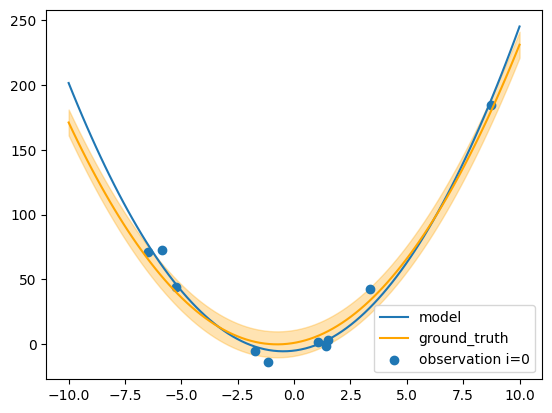

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from lib import experiment_runner as ground_truth, noise_std

def plot_results(controller_):
    last_model = controller_.state.filter_by(kind={"MODEL"}).history[-1].data

    x = np.linspace(-10, 10, 100).reshape((-1, 1))

    plt.plot(x, last_model.predict(x), label="model")

    plt.plot(x, ground_truth(x, noise_std_=0.), label="ground_truth", c="orange")
    plt.fill_between(x.flatten(), ground_truth(x, noise_std_=0.).flatten() + noise_std, ground_truth(x, noise_std_=0.).flatten() - noise_std,
                     alpha=0.3, color="orange")

    for i, observation in enumerate(controller_.state.filter_by(kind={"OBSERVATION"}).history):
        xi, yi = observation.data[:,0], observation.data[:,1]
        plt.scatter(xi, yi, label=f"observation {i=}")
    plt.legend()

plot_results(controller_result)

If we run the experiment for another 3 cycles, we can get results closer to the ground truth. In this example, we overwrite the results file each time the CLI is called.

In [ ]:
!cp "theorist-output.dill" "result.dill"
for i in range(9):  # each cycle has 3 steps, and we take 1 step per CLI call
    !python -m autora.workflow "result.dill" "result.dill"

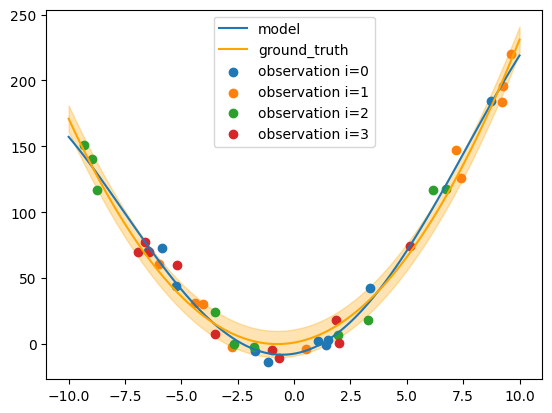

In [ ]:
with open("result.dill", "rb") as file:
    controller_after_3_cycles = dill.load(file)
plot_results(controller_after_3_cycles)

We can continue to run for as long as we like, e.g. another 10 cycles:

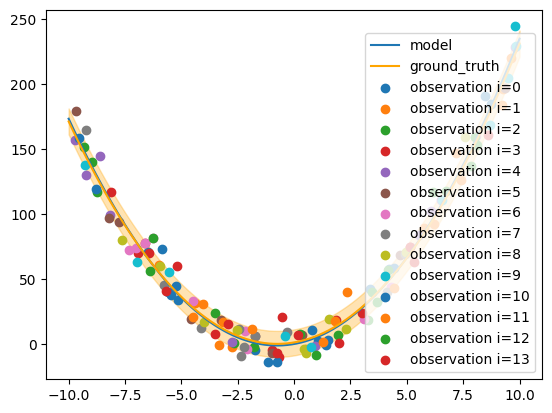

In [ ]:
!cp "result.dill" "result-30.dill"
for i in range(30):
    !python -m autora.workflow "result-30.dill" "result-30.dill"

with open("result-30.dill", "rb") as file:
    controller_after_13_cycles = dill.load(file)

plot_results(controller_after_13_cycles)